In [1]:
import numpy as np  # type: ignore
import onnx
import onnx.helper as h
import onnx.checker as checker
from onnx import TensorProto as tp
from onnx import save
import onnxruntime

import os
os.environ["ALLOW_RELEASED_ONNX_OPSET_ONLY"] = "0"

In [2]:
# Builds a pipeline that resizes and crops an input. 
def build_preprocessing_model(filename):
    nodes = []

    nodes.append(
        h.make_node('Shape', inputs=['x'], outputs=['x_shape'], name='x_shape')
    )

    nodes.append(
        h.make_node('Split', inputs=['x_shape'], outputs=['h', 'w', 'c'], axis=0, name='split_shape')
    )

    nodes.append(
        h.make_node('Min', inputs=['h', 'w'], outputs=['min_extent'], name='min_extent')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_256'], 
                    value=h.make_tensor(name='k256', data_type=tp.FLOAT, dims=[1], vals=[256.0]), 
                    name='constant_256')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_1'], 
                    value=h.make_tensor(name='k1', data_type=tp.FLOAT, dims=[1], vals=[1.0]),
                   name='constant_1')
    )

    nodes.append(
        h.make_node('Cast', inputs=['min_extent'], outputs=['min_extent_f'], to=tp.FLOAT, name='min_extent_f')
    )

    nodes.append(
        h.make_node('Div', inputs=['constant_256', 'min_extent_f'], outputs=['ratio-resize'], name='ratio-resize')
    )

    nodes.append(
        h.make_node('Concat', inputs=['ratio-resize', 'ratio-resize', 'constant_1'], outputs=['scales-resize'],
                    axis=0, name='scales-resize')
    )        

    nodes.append(
        h.make_node('Resize', inputs=['x', '', 'scales-resize'], outputs=['x_resized'], mode='linear', name='x_resize')
    )

    # Centered crop 224x224
    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_224'], 
                    value=h.make_tensor(name='k224', data_type=tp.INT64, dims=[1], vals=[224]), name='constant_224')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['constant_2'], 
                    value=h.make_tensor(name='k2', data_type=tp.INT64, dims=[1], vals=[2]), name='constant_2')
    )

    nodes.append(
        h.make_node('Shape', inputs=['x_resized'], outputs=['x_shape_2'], name='x_shape_2')
    )

    nodes.append(
        h.make_node('Split', inputs=['x_shape_2'], outputs=['h2', 'w2', 'c2'], name='split_shape_2')
    )

    nodes.append(
        h.make_node('Concat', inputs=['h2', 'w2'], outputs=['hw'], axis=0, name='concat_2')
    )   

    nodes.append(
        h.make_node('Sub', inputs=['hw', 'constant_224'], outputs=['hw_diff'], name='sub_224')
    )

    nodes.append(
        h.make_node('Div', inputs=['hw_diff', 'constant_2'], outputs=['start_xy'], name='div_2')
    )

    nodes.append(
        h.make_node('Add', inputs=['start_xy', 'constant_224'], outputs=['end_xy'], name='add_224')
    )

    nodes.append(
        h.make_node('Constant', inputs=[], outputs=['axes'], 
                    value=h.make_tensor(name='axes_k', data_type=tp.INT64, dims=[2], vals=[0, 1]), name='axes_k')
    )

    nodes.append(
        h.make_node('Slice', inputs=['x_resized', 'start_xy', 'end_xy', 'axes'], outputs=['x_processed'], name='x_crop')
    )

    # Create the graph
    g = h.make_graph(nodes, 'rn50-data-pipe-resize',
        [h.make_tensor_value_info('x', tp.UINT8, ['H', 'W', 3])],
        [h.make_tensor_value_info('x_processed', tp.UINT8, ['H', 'W', 3])]
    )

    # Make the preprocessing model
    op = onnx.OperatorSetIdProto()
    op.version = 14
    m = h.make_model(g, producer_name='onnx-preprocessing-resize-demo', opset_imports=[op])
    checker.check_model(m)

    # Save the model to a file
    save(m, filename)

build_preprocessing_model('preprocessing.onnx')

Output sizes: 
(1280, 853)
(1280, 911)


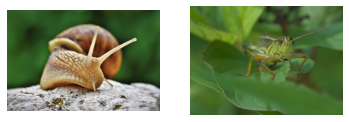

In [3]:
# display images in notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
%matplotlib inline

def show_images(images):
    nsamples = len(images)
    print("Output sizes: ")
    for i in range(nsamples):
        print(images[i].size)
    fig, axs = plt.subplots(1, nsamples)
    for i in range(nsamples):
        axs[i].axis('off')
        axs[i].imshow(images[i])
    plt.show()

images = [
    Image.open('../images/snail-4345504_1280.jpg'),
    Image.open('../images/grasshopper-4357903_1280.jpg')
]
show_images(images)


Output sizes: 
(224, 224)
(224, 224)


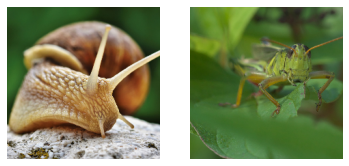

In [4]:
session = onnxruntime.InferenceSession('preprocessing.onnx', None)
out_images1 = []
for i in range(len(images)):
    img = np.array(images[i])
    result = session.run([], {'x': img})
    out_images1.append(Image.fromarray(result[0]))
show_images(out_images1)

In [5]:
import copy

preprocessing_model = onnx.load('preprocessing.onnx')
sample_graph = preprocessing_model.graph

def tensor_shape(t):
    return [d.dim_value or d.dim_param for d in t.type.tensor_type.shape.dim]

def tensor_dtype(t):
    return t.type.tensor_type.elem_type

def make_tensor_seq(t):
    return h.make_tensor_sequence_value_info(t.name, tensor_dtype(t), tensor_shape(t))

def sequence_processing_graph(sample_graph):
    seq_inputs = [make_tensor_seq(t) for t in sample_graph.input]
    seq_outputs = [make_tensor_seq(t) for t in sample_graph.output]

    nodes = []
        
    sample_graph = onnx.compose.add_prefix_graph(
        sample_graph, prefix='sample/', 
        rename_inputs=True, rename_outputs=True,
        rename_nodes=False, rename_edges=False,
        rename_initializers=False, rename_value_infos=False)
    
    nodes.append(
        onnx.helper.make_node(
            'SequenceMap',
            body=sample_graph,
            inputs=[entry.name for entry in seq_inputs],
            outputs=[entry.name for entry in seq_outputs]
        )
    )

    graph = onnx.helper.make_graph(
        nodes=nodes,
        name='seq_map_graph_' + sample_graph.name,
        inputs=seq_inputs,
        outputs=seq_outputs,
    )
    return graph

op = onnx.OperatorSetIdProto()
op.version = 16
graph = sequence_processing_graph(sample_graph)
model = onnx.helper.make_model(graph, producer_name='seq-map-test', opset_imports=[op])
onnx.checker.check_model(model)
onnx.save(model, "seq-map-test.onnx")

In [6]:
# Workaround to expand the SequenceMap function, which is not yet supported by ONNX runtime
from onnx.backend.test.case.node import function_testcase_helper
node = graph.node[0]
inputs_vi = graph.input
outputs_vi = graph.output
name = 'seqmap_expand'
kwargs = {}
def merge(node_inputs, present_value_info):  # type: (List[Text], List[onnx.ValueInfoProto]) -> List[TypeProto]
    if (node_inputs):
        if (node_inputs[0] != ''):
            return [present_value_info[0].type] + merge(node_inputs[1:], present_value_info[1:])
        else:
            return [TypeProto()] + merge(node_inputs[1:], present_value_info)
    return []
merged_types = merge(list(node.input), inputs_vi)
expanded_function_nodes = function_testcase_helper(node, merged_types, name)
if expanded_function_nodes:
    function_test_name = name + '_expanded'
    graph = onnx.helper.make_graph(
        nodes=expanded_function_nodes,
        name=function_test_name,
        inputs=inputs_vi,
        outputs=outputs_vi)
    kwargs[str('producer_name')] = 'backend-test'
    model = onnx.helper.make_model(graph, **kwargs)
    onnx.save(model, 'seq-map-expanded-test.onnx')

Outputs shape:  [(224, 224, 3), (224, 224, 3)]
Output sizes: 
(224, 224)
(224, 224)


2021-12-16 13:50:45.621520266 [W:onnxruntime:, model_load_utils.h:59 ValidateOpsetForDomain] ONNX Runtime only *guarantees* support for models stamped with official released onnx opset versions. Opset 16 is under development and support for this is limited. The operator schemas and or other functionality could possibly change before next ONNX release and in this case ONNX Runtime will not guarantee backward compatibility. Current official support for domain ai.onnx is till opset 15.
2021-12-16 13:50:45.622294758 [W:onnxruntime:, constant_folding.cc:162 ApplyImpl] Unsupported output type of N11onnxruntime22SequenceTensorTypeBaseE. Can't constant fold SequenceEmpty node ''
2021-12-16 13:50:45.622576370 [W:onnxruntime:, constant_folding.cc:162 ApplyImpl] Unsupported output type of N11onnxruntime22SequenceTensorTypeBaseE. Can't constant fold SequenceEmpty node ''


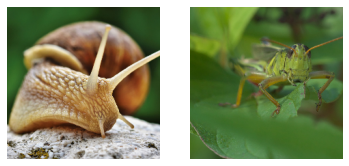

In [7]:
session = onnxruntime.InferenceSession("seq-map-expanded-test.onnx", None)
imgs = [np.array(image) for image in images]
result = session.run([], {'x' : imgs})
print("Outputs shape: ", [result[0][i].shape for i in range(len(imgs))])
out_images2 = [Image.fromarray(result[0][i]) for i in range(len(imgs))]
show_images(out_images2)